## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

In [2]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [3]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [4]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [5]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

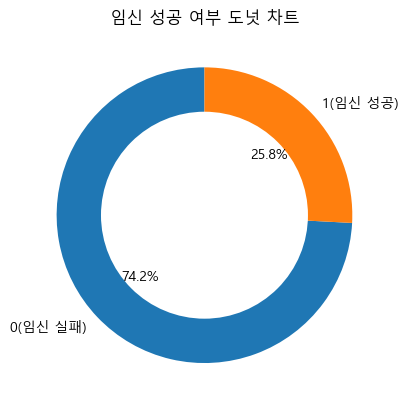

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [7]:
# '시술_시기_코드' 변수의 값이 'TRXQMD'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_시기_코드'] == 'TRXQMD'] 
IVF_test = test[test['시술_시기_코드'] == 'TRXQMD']

# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

train = IVF_train
test = IVF_test

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [8]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRXQMD    0.743878  0.256122  25910  8921  34831


In [9]:
# '시술_시기_코드' 변수 제거
train = train.drop(columns=['시술_시기_코드'])
test = test.drop(columns=['시술_시기_코드'])

### 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [10]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
만18-34세   0.684184  0.315816  9504.0  4387.0  13891
만35-37세   0.721422  0.278578  5863.0  2264.0   8127
만38-39세   0.782838  0.217162  4452.0  1235.0   5687
만40-42세   0.839542  0.160458  4102.0   784.0   4886
만43-44세   0.902029  0.097971  1289.0   140.0   1429
만45-50세   0.859494  0.140506   679.0   111.0    790
알 수 없음    1.000000  0.000000    21.0     0.0     21


In [11]:
test['시술_당시_나이'].value_counts()

만18-34세    4789
만35-37세    2774
만38-39세    1934
만40-42세    1789
만43-44세     466
만45-50세     265
알 수 없음        2
Name: 시술_당시_나이, dtype: int64

### 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [12]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0.0       0.666667  0.333333    2.0    1.0      3
1.0       1.000000  0.000000    2.0    0.0      2
2.0       0.692308  0.307692    9.0    4.0     13
3.0       0.750000  0.250000   51.0   17.0     68
4.0       0.759494  0.240506  180.0   57.0    237
5.0       0.746641  0.253359  389.0  132.0    521
6.0       0.737274  0.262726  449.0  160.0    609
7.0       0.775385  0.224615  504.0  146.0    650
8.0       0.782123  0.217877  420.0  117.0    537
9.0       0.818667  0.181333  307.0   68.0    375
10.0      0.789625  0.210375  274.0   73.0    347
11.0      0.814480  0.185520  180.0   41.0    221
12.0      0.791411  0.208589  129.0   34.0    163
13.0      0.847222  0.152778  122.0   22.0    144
14.0      0.727273  0.272727   56.0   21.0     77
15.0      0.754386  0.245614   43.0   14.0     57
16.0      0.846154  0.153846   44.0    8.0     52
17.0    

In [13]:
# 3년 단위로 범주화
bins = list(range(0, 24, 3))  # 0부터 20까지 3년 단위로 구간 생성
labels = [f'{i}-{i+2}년' for i in range(0, 21, 3)]  # 범주 레이블 생성

train['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(train['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)
test['임신_시도_또는_마지막_임신_경과_연수'] = pd.cut(test['임신_시도_또는_마지막_임신_경과_연수'], bins=bins, labels=labels, right=False)

# 결측값을 'unknown'으로 채우기 위해 범주에 'unknown' 추가
train['임신_시도_또는_마지막_임신_경과_연수'] = train['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])
test['임신_시도_또는_마지막_임신_경과_연수'] = test['임신_시도_또는_마지막_임신_경과_연수'].cat.add_categories(['unknown'])

train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

In [14]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0-2년      0.722222  0.277778     13     5     18
3-5년      0.750605  0.249395    620   206    826
6-8년      0.764477  0.235523   1373   423   1796
9-11년     0.806999  0.193001    761   182    943
12-14년    0.799479  0.200521    307    77    384
15-17년    0.810811  0.189189    120    28    148
18-20년    0.835165  0.164835     76    15     91
unknown   0.739265  0.260735  22640  7985  30625


### 4. 시술_유형

IVF 또는 DI 시술 여부

In [15]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
DI        0.837808  0.162192    749   145    894
IVF       0.741403  0.258597  25161  8776  33937


In [16]:
test['시술_유형'].value_counts()

IVF    11701
DI       318
Name: 시술_유형, dtype: int64

### 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [17]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                                  group  '임신_성공_여부' count     ratio  Total
0                                  GIFT                 0  0.000000      1
1                            Generic DI                 1  0.500000      2
2                                   ICI                 7  0.179487     39
3                                  ICSI              4263  0.267256  15951
4                             ICSI / AH                82  0.240469    341
5                    ICSI / BLASTOCYST                266  0.394074    675
6   ICSI / BLASTOCYST :IVF / BLASTOCYST                 1  1.000000      1
7    ICSI / BLASTOCYST:IVF / BLASTOCYST                 2  0.666667      3
8                             ICSI:ICSI                 2  0.017857    112
9                              ICSI:IVF                37  0.321739    115
10                         ICSI:Unknown                 4  0.307692     13
11                                  IUI               137  0.161176    850
12 

In [18]:
test['특정_시술_유형'].value_counts()

ICSI                                  5479
IVF                                   4304
Unknown                               1208
IUI                                    300
ICSI / BLASTOCYST                      243
IVF / BLASTOCYST                       159
ICSI / AH                              120
IVF / AH                                49
ICSI:ICSI                               47
ICSI:IVF                                40
IVF:IVF                                 26
IVF:ICSI                                19
ICI                                     13
ICSI:Unknown                             3
IVF:Unknown                              3
IUI:ICI                                  2
IVI                                      2
Generic DI                               1
ICSI / BLASTOCYST:IVF / BLASTOCYST       1
Name: 특정_시술_유형, dtype: int64

In [19]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
# test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [20]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
        elif treatment == "IUI:ICI":
            return "IUI"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [21]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1        0       1  Total
variable                                                     
Generic DI         0.500000  0.500000      1.0     1.0      2
ICI                0.820513  0.179487     32.0     7.0     39
ICSI               0.734050  0.265950  11885.0  4306.0  16191
ICSI / AH          0.759531  0.240469    259.0    82.0    341
ICSI / BLASTOCYST  0.603829  0.396171    410.0   269.0    679
IUI                0.838824  0.161176    713.0   137.0    850
IVF                0.740626  0.259374   9343.0  3272.0  12615
IVF / AH           0.796053  0.203947    121.0    31.0    152
IVF / BLASTOCYST   0.606786  0.393214    304.0   197.0    501
IVI                1.000000  0.000000      2.0     0.0      2
Unknown            0.820995  0.179005   2839.0   619.0   3458


In [22]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 5569
IVF                  4352
Unknown              1208
IUI                   302
ICSI / BLASTOCYST     244
IVF / BLASTOCYST      159
ICSI / AH             120
IVF / AH               49
ICI                    13
IVI                     2
Generic DI              1
Name: 변환된_특정_시술_유형, dtype: int64

In [23]:
# 더미 변수 생성 함수 정의
def create_dummy(x, keyword):
    if isinstance(x, str) and keyword in x:
        return 1
    else:
        return 0

# 더미 변수 생성
train['특정_시술_유형_ICSI_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
train['특정_시술_유형_IVF_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
train['특정_시술_유형_AH_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
train['특정_시술_유형_BLASTOCYST_더미'] = train['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

test['특정_시술_유형_ICSI_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'ICSI'))
test['특정_시술_유형_IVF_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'IVF'))
test['특정_시술_유형_AH_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'AH'))
test['특정_시술_유형_BLASTOCYST_더미'] = test['변환된_특정_시술_유형'].apply(lambda x: create_dummy(x, 'BLASTOCYST'))

In [24]:
summarize_group(train, ['특정_시술_유형',
                        '특정_시술_유형_ICSI_더미',
                          '특정_시술_유형_IVF_더미',
                            '특정_시술_유형_AH_더미',
                              '특정_시술_유형_BLASTOCYST_더미'])

Grouped by: 특정_시술_유형, 특정_시술_유형_ICSI_더미, 특정_시술_유형_IVF_더미, 특정_시술_유형_AH_더미, 특정_시술_유형_BLASTOCYST_더미

                                                group  '임신_성공_여부' count  \
0                            (Generic DI, 0, 0, 0, 0)                 1   
1                                   (ICI, 0, 0, 0, 0)                 7   
2                                  (ICSI, 1, 0, 0, 0)              4263   
3                             (ICSI / AH, 1, 0, 1, 0)                82   
4                    (ICSI / BLASTOCYST , 1, 0, 0, 1)               266   
5   (ICSI / BLASTOCYST :IVF / BLASTOCYST, 1, 0, 0, 1)                 1   
6    (ICSI / BLASTOCYST:IVF / BLASTOCYST, 1, 0, 0, 1)                 2   
7                             (ICSI:ICSI, 1, 0, 0, 0)                 2   
8                              (ICSI:IVF, 1, 0, 0, 0)                37   
9                          (ICSI:Unknown, 1, 0, 0, 0)                 4   
10                                  (IUI, 0, 0, 0, 0)               137   
11 

In [25]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

### 6. 배란_자극_여부

배란 자극 치료가 사용되었는지 여부

In [26]:
value_counts_ratio(train, '배란_자극_여부')


배란_자극_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.802832  0.197168   6010  1476   7486
1         0.727728  0.272272  19899  7445  27344


### 7. 배란_유도_유형

사용된 배란 유도 방법 유형

In [27]:
value_counts_ratio(train, '배란_유도_유형')


배란_유도_유형별 임신_성공_여부 비율 및 갯수

                   0         1      0     1  Total
variable                                          
기록되지 않은 시행  0.726008  0.273992  19518  7366  26884
알 수 없음      0.804304  0.195696   6391  1555   7946


In [28]:
test['배란_유도_유형'].value_counts()

기록되지 않은 시행    9307
알 수 없음        2712
Name: 배란_유도_유형, dtype: int64

### 8. 단일_배아_이식_여부

선택적으로 단일 배아를 이식했는지 여부

In [29]:
value_counts_ratio(train, '단일_배아_이식_여부')


단일_배아_이식_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.755106  0.244894  21701  7038  28739
1.0       0.665641  0.334359   3460  1738   5198


### 9. 착상_전_유전_검사_사용_여부

PGS(착상 전 유전 검사)가 시행되었는지 여부

In [30]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                0        1    0   1  Total
variable                                  
1.0       0.87218  0.12782  232  34    266


In [31]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 34564
결측값 개수: 0


In [32]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.742883  0.257117  25677  8887  34564
1.0       0.872180  0.127820    232    34    266


### 10. 착상_전_유전_진단_사용_여부

PGD(착상 전 유전 진단)가 시행되었는지 여부

In [33]:
value_counts_ratio(train, '착상_전_유전_진단_사용_여부')


착상_전_유전_진단_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.741743  0.258257  24973  8695  33668
1.0       0.698885  0.301115    188    81    269


In [34]:
summarize_group(train, ['착상_전_유전_진단_사용_여부', '착상_전_유전_검사_사용_여부'])

Grouped by: 착상_전_유전_진단_사용_여부, 착상_전_유전_검사_사용_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              8661  0.259280  33404
1  (0.0, 1.0)                34  0.128788    264
2  (1.0, 0.0)                81  0.303371    267
3  (1.0, 1.0)                 0  0.000000      2


### 11. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [35]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741207  0.258793  23414  8175  31589
1         0.769824  0.230176   2495   746   3241


### 12. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [36]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741489  0.258511  24722  8619  33341
1         0.797179  0.202821   1187   302   1489


In [37]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              7873  0.261544  30102
1  (0, 1)               302  0.203093   1487
2  (1, 0)               746  0.230318   3239
3  (1, 1)                 0  0.000000      2


### 13. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [38]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741077  0.258923  23255  8125  31380
1         0.769275  0.230725   2654   796   3450


### 14. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [39]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741390  0.258610  24755  8635  33390
1         0.801389  0.198611   1154   286   1440


In [40]:
summarize_group(train, ['여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 여성_주_불임_원인, 여성_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              7840  0.261840  29942
1  (0, 1)               285  0.198192   1438
2  (1, 0)               795  0.230568   3448
3  (1, 1)                 1  0.500000      2


In [41]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인', '여성_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인

           group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0)              7834  0.261858  29917
1   (0, 0, 0, 1)                 7  0.159091     44
2   (0, 0, 1, 0)                32  0.228571    140
3   (0, 0, 1, 1)                 0  0.000000      1
4   (0, 1, 0, 0)                 2  0.222222      9
5   (0, 1, 0, 1)               202  0.199802   1011
6   (0, 1, 1, 0)                97  0.208155    466
7   (0, 1, 1, 1)                 1  1.000000      1
8   (1, 0, 0, 0)                 4  0.250000     16
9   (1, 0, 0, 1)                76  0.198953    382
10  (1, 0, 1, 0)               666  0.234424   2841
11  (1, 1, 0, 1)                 0  0.000000      1
12  (1, 1, 1, 0)                 0  0.000000      1


### 15. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [42]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.740980  0.259020  23043  8055  31098
1         0.767953  0.232047   2866   866   3732


### 16. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [43]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741691  0.258309  25084  8736  33820
1         0.816832  0.183168    825   185   1010


In [44]:
summarize_group(train, ['부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 부부_주_불임_원인, 부부_부_불임_원인

    group  '임신_성공_여부' count     ratio  Total
0  (0, 0)              7870  0.261557  30089
1  (0, 1)               185  0.183350   1009
2  (1, 0)               866  0.232109   3731
3  (1, 1)                 0  0.000000      1


In [45]:
summarize_group(train, ['남성_주_불임_원인', '남성_부_불임_원인'
                        , '여성_주_불임_원인', '여성_부_불임_원인'
                        , '부부_주_불임_원인', '부부_부_불임_원인'])

Grouped by: 남성_주_불임_원인, 남성_부_불임_원인, 여성_주_불임_원인, 여성_부_불임_원인, 부부_주_불임_원인, 부부_부_불임_원인

                 group  '임신_성공_여부' count     ratio  Total
0   (0, 0, 0, 0, 0, 0)              7827  0.261764  29901
1   (0, 0, 0, 0, 0, 1)                 1  0.500000      2
2   (0, 0, 0, 0, 1, 0)                 6  0.428571     14
3   (0, 0, 0, 1, 0, 0)                 6  0.176471     34
4   (0, 0, 0, 1, 0, 1)                 1  0.125000      8
5   (0, 0, 0, 1, 1, 0)                 0  0.000000      2
6   (0, 0, 1, 0, 0, 0)                20  0.192308    104
7   (0, 0, 1, 0, 0, 1)                 1  0.500000      2
8   (0, 0, 1, 0, 1, 0)                11  0.323529     34
9   (0, 0, 1, 1, 1, 0)                 0  0.000000      1
10  (0, 1, 0, 0, 0, 1)                 2  0.222222      9
11  (0, 1, 0, 1, 0, 0)                 6  0.333333     18
12  (0, 1, 0, 1, 0, 1)               164  0.185311    885
13  (0, 1, 0, 1, 1, 0)                32  0.299065    107
14  (0, 1, 0, 1, 1, 1)                 0  0.00

### 17. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [46]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.745087  0.254913  19411  6641  26052
1         0.740260  0.259740   6498  2280   8778


### 18. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [47]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741386  0.258614  21561  7521  29082
1         0.756437  0.243563   4348  1400   5748


### 19. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [48]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.751986  0.248014  15524  5120  20644
1         0.732060  0.267940  10385  3801  14186


### 20. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [49]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.745727  0.254273  22644  7721  30365
1         0.731243  0.268757   3265  1200   4465


### 21. 불임_원인_-_여성_요인

여성 요인으로 인한 불임 여부

In [50]:
value_counts_ratio(train, '불임_원인_-_여성_요인')


불임_원인_-_여성_요인별 임신_성공_여부 비율 및 갯수

                0        1      0     1  Total
variable                                      
0         0.74387  0.25613  25909  8921  34830


In [51]:
test['불임_원인_-_여성_요인'].value_counts()

0    12019
Name: 불임_원인_-_여성_요인, dtype: int64

In [52]:
# '불임_원인_-_여성_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_여성_요인'])
test = test.drop(columns=['불임_원인_-_여성_요인'])

### 22. 불임_원인_-_자궁경부_문제

자궁경부 이상으로 인한 불임 여부

In [53]:
value_counts_ratio(train, '불임_원인_-_자궁경부_문제')


불임_원인_-_자궁경부_문제별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.743833  0.256167  25904.0  8921.0  34825
1         1.000000  0.000000      5.0     0.0      5


### 23. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [54]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.742438  0.257562  24006  8328  32334
1         0.762420  0.237580   1903   593   2496


### 24. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [55]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743848  0.256152  25816  8890  34706
1         0.750000  0.250000     93    31    124


### 25. 불임_원인_-_정자_면역학적_요인

파트너의 정자 면역 관련 문제 여부

In [56]:
value_counts_ratio(train, '불임_원인_-_정자_면역학적_요인')


불임_원인_-_정자_면역학적_요인별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.743863  0.256137  25908.0  8921.0  34829
1         1.000000  0.000000      1.0     0.0      1


In [57]:
test['불임_원인_-_정자_면역학적_요인'].value_counts()

0    12018
1        1
Name: 불임_원인_-_정자_면역학적_요인, dtype: int64

In [58]:
# '불임_원인_-_정자_면역학적_요인' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_면역학적_요인'])
test = test.drop(columns=['불임_원인_-_정자_면역학적_요인'])

### 26. 불임_원인_-_정자_운동성

파트너의 정자 운동성 문제 여부

In [59]:
value_counts_ratio(train, '불임_원인_-_정자_운동성')


불임_원인_-_정자_운동성별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743761  0.256239  25868  8912  34780
1         0.820000  0.180000     41     9     50


In [60]:
# '불임_원인_-_정자_운동성' 변수 제거
train = train.drop(columns=['불임_원인_-_정자_운동성'])
test = test.drop(columns=['불임_원인_-_정자_운동성'])

### 27. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [61]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743773  0.256227  25858  8908  34766
1         0.796875  0.203125     51    13     64


### 28. 배아_생성_주요_이유

배아 생성의 주된 목적(시술, 보관 등)

In [62]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    113.0     0.0    113
기증용, 난자 저장용          1.000000  0.000000      3.0     0.0      3
기증용, 배아 저장용          1.000000  0.000000      4.0     0.0      4
기증용, 배아 저장용, 현재 시술용  0.500000  0.500000      2.0     2.0      4
기증용, 현재 시술용          0.631410  0.368590    394.0   230.0    624
난자 저장용               1.000000  0.000000    136.0     0.0    136
배아 저장용               1.000000  0.000000    142.0     0.0    142
배아 저장용, 현재 시술용       0.400000  0.600000      2.0     3.0      5
현재 시술용               0.740442  0.259558  24365.0  8541.0  32906


In [63]:
# '연구용'이라는 값이 포함된 행 삭제
train = train[~train['배아_생성_주요_이유'].str.contains('연구용', na=False)]
# test = test[~test['배아_생성_주요_이유'].str.contains('연구용', na=False)]

In [64]:
value_counts_ratio(train, '배아_생성_주요_이유')


배아_생성_주요_이유별 임신_성공_여부 비율 및 갯수

                            0         1        0       1  Total
variable                                                       
기증용                  1.000000  0.000000    113.0     0.0    113
기증용, 난자 저장용          1.000000  0.000000      3.0     0.0      3
기증용, 배아 저장용          1.000000  0.000000      4.0     0.0      4
기증용, 배아 저장용, 현재 시술용  0.500000  0.500000      2.0     2.0      4
기증용, 현재 시술용          0.631410  0.368590    394.0   230.0    624
난자 저장용               1.000000  0.000000    136.0     0.0    136
배아 저장용               1.000000  0.000000    142.0     0.0    142
배아 저장용, 현재 시술용       0.400000  0.600000      2.0     3.0      5
현재 시술용               0.740442  0.259558  24365.0  8541.0  32906


In [65]:
test['배아_생성_주요_이유'].value_counts()

현재 시술용                 11373
기증용, 현재 시술용              204
배아 저장용                    52
난자 저장용                    36
기증용                       30
기증용, 난자 저장용                3
배아 저장용, 현재 시술용             2
기증용, 배아 저장용, 현재 시술용        1
Name: 배아_생성_주요_이유, dtype: int64

In [66]:
print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

train['배아_생성_주요_이유'].fillna('unknown', inplace=True)
test['배아_생성_주요_이유'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_생성_주요_이유'].isnull().sum())

결측값 개수: 893
결측값 개수: 0


In [67]:
# '현재 시술용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_현재시술용'] = train['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)
test['배아_생성_주요_이유_현재시술용'] = test['배아_생성_주요_이유'].str.contains('현재 시술용').astype(int)

In [68]:
# '기증용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_기증용'] = train['배아_생성_주요_이유'].str.contains('기증용').astype(int)
test['배아_생성_주요_이유_기증용'] = test['배아_생성_주요_이유'].str.contains('기증용').astype(int)

In [69]:
# '난자 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_난자저장용'] = train['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)
test['배아_생성_주요_이유_난자저장용'] = test['배아_생성_주요_이유'].str.contains('난자 저장용').astype(int)

In [70]:
# '배아 저장용' 키워드가 포함된 경우 1, 그렇지 않은 경우 0을 부여하는 더미 변수 생성
train['배아_생성_주요_이유_배아저장용'] = train['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)
test['배아_생성_주요_이유_배아저장용'] = test['배아_생성_주요_이유'].str.contains('배아 저장용').astype(int)

In [71]:
summarize_group(train, [
    # '배아_생성_주요_이유',
    '배아_생성_주요_이유_현재시술용',
    '배아_생성_주요_이유_기증용',
    '배아_생성_주요_이유_난자저장용',
    '배아_생성_주요_이유_배아저장용'
                        ])

Grouped by: 배아_생성_주요_이유_현재시술용, 배아_생성_주요_이유_기증용, 배아_생성_주요_이유_난자저장용, 배아_생성_주요_이유_배아저장용

          group  '임신_성공_여부' count     ratio  Total
0  (0, 0, 0, 0)               145  0.162374    893
1  (0, 0, 0, 1)                 0  0.000000    142
2  (0, 0, 1, 0)                 0  0.000000    136
3  (0, 1, 0, 0)                 0  0.000000    113
4  (0, 1, 0, 1)                 0  0.000000      4
5  (0, 1, 1, 0)                 0  0.000000      3
6  (1, 0, 0, 0)              8541  0.259558  32906
7  (1, 0, 0, 1)                 3  0.600000      5
8  (1, 1, 0, 0)               230  0.368590    624
9  (1, 1, 0, 1)                 2  0.500000      4


In [72]:
value_counts_ratio(train, '배아_생성_주요_이유_현재시술용')


배아_생성_주요_이유_현재시술용별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.887684  0.112316   1146   145   1291
1         0.738334  0.261666  24763  8776  33539


In [73]:
# # 변수 제거
# train = train.drop(columns=['배아_생성_주요_이유'])
# test = test.drop(columns=['배아_생성_주요_이유'])

### 29. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [74]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0회        0.697702  0.302298  8865  3841  12706
1회        0.757974  0.242026  6226  1988   8214
2회        0.762123  0.237877  4322  1349   5671
3회        0.774260  0.225740  2617   763   3380
4회        0.781874  0.218126  1527   426   1953
5회        0.794145  0.205855   868   225   1093
6회 이상     0.818533  0.181467  1484   329   1813


In [75]:
test['총_시술_횟수'].value_counts()

0회       4431
1회       2793
2회       1989
3회       1183
6회 이상     617
4회        601
5회        405
Name: 총_시술_횟수, dtype: int64

In [76]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_시술_횟수'] = train['총_시술_횟수'].map(mapping)
test['총_시술_횟수'] = test['총_시술_횟수'].map(mapping)

value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0         0.697702  0.302298  8865  3841  12706
1         0.757974  0.242026  6226  1988   8214
2         0.762123  0.237877  4322  1349   5671
3         0.774260  0.225740  2617   763   3380
4         0.781874  0.218126  1527   426   1953
5         0.794145  0.205855   868   225   1093
6         0.818533  0.181467  1484   329   1813


### 30. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [77]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.708770  0.291230  11436  4699  16135
1회        0.761933  0.238067   6481  2025   8506
2회        0.768505  0.231495   3748  1129   4877
3회        0.792476  0.207524   1959   513   2472
4회        0.793495  0.206505   1049   273   1322
5회        0.799378  0.200622    514   129    643
6회 이상     0.825143  0.174857    722   153    875


In [78]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['클리닉_내_총_시술_횟수'] = train['클리닉_내_총_시술_횟수'].map(mapping)
test['클리닉_내_총_시술_횟수'] = test['클리닉_내_총_시술_횟수'].map(mapping)

value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.708770  0.291230  11436  4699  16135
1         0.761933  0.238067   6481  2025   8506
2         0.768505  0.231495   3748  1129   4877
3         0.792476  0.207524   1959   513   2472
4         0.793495  0.206505   1049   273   1322
5         0.799378  0.200622    514   129    643
6         0.825143  0.174857    722   153    875


### 31. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [79]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0회        0.704103  0.295897  9611  4039  13650
1회        0.757623  0.242377  6336  2027   8363
2회        0.759226  0.240774  4279  1357   5636
3회        0.777847  0.222153  2514   718   3232
4회        0.782559  0.217441  1382   384   1766
5회        0.805763  0.194237   755   182    937
6회 이상     0.828250  0.171750  1032   214   1246


In [80]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_시술_횟수'] = train['IVF_시술_횟수'].map(mapping)
test['IVF_시술_횟수'] = test['IVF_시술_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0         0.704103  0.295897  9611  4039  13650
1         0.757623  0.242377  6336  2027   8363
2         0.759226  0.240774  4279  1357   5636
3         0.777847  0.222153  2514   718   3232
4         0.782559  0.217441  1382   384   1766
5         0.805763  0.194237   755   182    937
6         0.828250  0.171750  1032   214   1246


### 32. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [81]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.741122  0.258878  24437  8536  32973
1회        0.822823  0.177177    274    59    333
2회        0.810026  0.189974    307    72    379
3회        0.762295  0.237705    279    87    366
4회        0.757322  0.242678    181    58    239
5회        0.813953  0.186047    140    32    172
6회 이상     0.790761  0.209239    291    77    368


In [82]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['DI_시술_횟수'] = train['DI_시술_횟수'].map(mapping)
test['DI_시술_횟수'] = test['DI_시술_횟수'].map(mapping)

value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.741122  0.258878  24437  8536  32973
1         0.822823  0.177177    274    59    333
2         0.810026  0.189974    307    72    379
3         0.762295  0.237705    279    87    366
4         0.757322  0.242678    181    58    239
5         0.813953  0.186047    140    32    172
6         0.790761  0.209239    291    77    368


### 33. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [83]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.743256  0.256744  20774.0  7176.0  27950
1회        0.744818  0.255182   4492.0  1539.0   6031
2회        0.750323  0.249677    580.0   193.0    773
3회        0.820896  0.179104     55.0    12.0     67
4회        0.875000  0.125000      7.0     1.0      8
5회        1.000000  0.000000      1.0     0.0      1


In [84]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_임신_횟수'] = train['총_임신_횟수'].map(mapping)
test['총_임신_횟수'] = test['총_임신_횟수'].map(mapping)

value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.743256  0.256744  20774.0  7176.0  27950
1         0.744818  0.255182   4492.0  1539.0   6031
2         0.750323  0.249677    580.0   193.0    773
3         0.820896  0.179104     55.0    12.0     67
4         0.875000  0.125000      7.0     1.0      8
5         1.000000  0.000000      1.0     0.0      1


### 34. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [85]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.744017  0.255983  21142.0  7274.0  28416
1회        0.740773  0.259227   4195.0  1468.0   5663
2회        0.755132  0.244868    515.0   167.0    682
3회        0.816667  0.183333     49.0    11.0     60
4회        0.875000  0.125000      7.0     1.0      8
5회        1.000000  0.000000      1.0     0.0      1


In [86]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['IVF_임신_횟수'] = train['IVF_임신_횟수'].map(mapping)
test['IVF_임신_횟수'] = test['IVF_임신_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.744017  0.255983  21142.0  7274.0  28416
1         0.740773  0.259227   4195.0  1468.0   5663
2         0.755132  0.244868    515.0   167.0    682
3         0.816667  0.183333     49.0    11.0     60
4         0.875000  0.125000      7.0     1.0      8
5         1.000000  0.000000      1.0     0.0      1


### 35. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [87]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0회        0.743266  0.256734  25526  8817  34343
1회        0.796069  0.203931    324    83    407
2회        0.736842  0.263158     56    20     76
3회        0.750000  0.250000      3     1      4


In [88]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_임신_횟수'] = train['DI_임신_횟수'].map(mapping)
test['DI_임신_횟수'] = test['DI_임신_횟수'].map(mapping)

value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.743266  0.256734  25526  8817  34343
1         0.796069  0.203931    324    83    407
2         0.736842  0.263158     56    20     76
3         0.750000  0.250000      3     1      4


### 36. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [89]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.744295  0.255705  22145.0  7608.0  29753
1회        0.740346  0.259654   3547.0  1244.0   4791
2회        0.750943  0.249057    199.0    66.0    265
3회        0.842105  0.157895     16.0     3.0     19
4회        1.000000  0.000000      2.0     0.0      2


In [90]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5,
    '6회 이상': 6
}

# 숫자로 변환
train['총_출산_횟수'] = train['총_출산_횟수'].map(mapping)
test['총_출산_횟수'] = test['총_출산_횟수'].map(mapping)

value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.744295  0.255705  22145.0  7608.0  29753
1         0.740346  0.259654   3547.0  1244.0   4791
2         0.750943  0.249057    199.0    66.0    265
3         0.842105  0.157895     16.0     3.0     19
4         1.000000  0.000000      2.0     0.0      2


### 37. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [91]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.744783  0.255217  22450.0  7693.0  30143
1회        0.737279  0.262721   3289.0  1172.0   4461
2회        0.742718  0.257282    153.0    53.0    206
3회        0.833333  0.166667     15.0     3.0     18
4회        1.000000  0.000000      2.0     0.0      2


In [92]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['IVF_출산_횟수'] = train['IVF_출산_횟수'].map(mapping)
test['IVF_출산_횟수'] = test['IVF_출산_횟수'].map(mapping)

value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.744783  0.255217  22450.0  7693.0  30143
1         0.737279  0.262721   3289.0  1172.0   4461
2         0.742718  0.257282    153.0    53.0    206
3         0.833333  0.166667     15.0     3.0     18
4         1.000000  0.000000      2.0     0.0      2


In [93]:
test['IVF_출산_횟수'].value_counts()

0    10328
1     1612
2       74
3        3
4        2
Name: IVF_출산_횟수, dtype: int64

### 38. DI_출산_횟수

DI 시술로 출산한 횟수

In [94]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0회        0.743451  0.256549  25600.0  8834.0  34434
1회        0.777778  0.222222    266.0    76.0    342
2회        0.792453  0.207547     42.0    11.0     53
3회        1.000000  0.000000      1.0     0.0      1


In [95]:
# 숫자 매핑
mapping = {
    '0회': 0,
    '1회': 1,
    '2회': 2,
    '3회': 3,
    '4회': 4,
    '5회': 5
}

# 숫자로 변환
train['DI_출산_횟수'] = train['DI_출산_횟수'].map(mapping)
test['DI_출산_횟수'] = test['DI_출산_횟수'].map(mapping)

value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0         0.743451  0.256549  25600.0  8834.0  34434
1         0.777778  0.222222    266.0    76.0    342
2         0.792453  0.207547     42.0    11.0     53
3         1.000000  0.000000      1.0     0.0      1


In [96]:
test['DI_출산_횟수'].value_counts()

0    11893
1      113
2       12
5        1
Name: DI_출산_횟수, dtype: int64

In [97]:
# # 모든 행과 열을 다 보이게 설정
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [98]:
# summarize_group(train, ['IVF_시술_횟수', 'IVF_임신_횟수', 'IVF_출산_횟수'])

In [99]:
# 주요 비율 계산 (train 데이터프레임)
train['IVF_임신_시술_비율'] = np.where(train['IVF_시술_횟수'] > 0, train['IVF_임신_횟수'] / train['IVF_시술_횟수'], 0)
train['IVF_출산_임신_비율'] = np.where(train['IVF_임신_횟수'] > 0, train['IVF_출산_횟수'] / train['IVF_임신_횟수'], 0)

train['DI_임신_시술_비율'] = np.where(train['DI_시술_횟수'] > 0, train['DI_임신_횟수'] / train['DI_시술_횟수'], 0)
train['DI_출산_임신_비율'] = np.where(train['DI_임신_횟수'] > 0, train['DI_출산_횟수'] / train['DI_임신_횟수'], 0)

# 성공률 계산
train['임신_성공률'] = np.where(train['총_시술_횟수'] > 0, train['총_임신_횟수'] / train['총_시술_횟수'], 0)
train['출산_성공률'] = np.where(train['총_임신_횟수'] > 0, train['총_출산_횟수'] / train['총_임신_횟수'], 0)

# 주요 비율 계산 (test 데이터프레임)
test['IVF_임신_시술_비율'] = np.where(test['IVF_시술_횟수'] > 0, test['IVF_임신_횟수'] / test['IVF_시술_횟수'], 0)
test['IVF_출산_임신_비율'] = np.where(test['IVF_임신_횟수'] > 0, test['IVF_출산_횟수'] / test['IVF_임신_횟수'], 0)

test['DI_임신_시술_비율'] = np.where(test['DI_시술_횟수'] > 0, test['DI_임신_횟수'] / test['DI_시술_횟수'], 0)
test['DI_출산_임신_비율'] = np.where(test['DI_임신_횟수'] > 0, test['DI_출산_횟수'] / test['DI_임신_횟수'], 0)

# 성공률 계산
test['임신_성공률'] = np.where(test['총_시술_횟수'] > 0, test['총_임신_횟수'] / test['총_시술_횟수'], 0)
test['출산_성공률'] = np.where(test['총_임신_횟수'] > 0, test['총_출산_횟수'] / test['총_임신_횟수'], 0)

### 39. 총_생성_배아_수

해당 시술에서 생성된 배아의 총 개수

In [100]:
value_counts_ratio(train, '총_생성_배아_수')


총_생성_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.859304  0.140696  6248.0  1023.0   7271
1.0       0.913957  0.086043  1827.0   172.0   1999
2.0       0.803642  0.196358  2030.0   496.0   2526
3.0       0.760383  0.239617  2142.0   675.0   2817
4.0       0.729820  0.270180  2188.0   810.0   2998
5.0       0.692716  0.307284  1959.0   869.0   2828
6.0       0.670139  0.329861  1737.0   855.0   2592
7.0       0.670799  0.329201  1461.0   717.0   2178
8.0       0.649921  0.350079  1229.0   662.0   1891
9.0       0.634971  0.365029   995.0   572.0   1567
10.0      0.622474  0.377526   770.0   467.0   1237
11.0      0.606405  0.393595   587.0   381.0    968
12.0      0.651015  0.348985   513.0   275.0    788
13.0      0.621951  0.378049   357.0   217.0    574
14.0      0.567308  0.432692   236.0   180.0    416
15.0      0.658537  0.341463   216.0   112.0    328
16.0      0.601732  0.398268   139

### 40. 미세주입된_난자_수

정자 미세주입(ICSI)으로 처리된 난자의 수

In [101]:
value_counts_ratio(train, '미세주입된_난자_수')


미세주입된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.759604  0.240396  13426.0  4249.0  17675
1.0       0.947262  0.052738    467.0    26.0    493
2.0       0.895141  0.104859    700.0    82.0    782
3.0       0.826471  0.173529    843.0   177.0   1020
4.0       0.785388  0.214612   1032.0   282.0   1314
5.0       0.741637  0.258363   1042.0   363.0   1405
6.0       0.732094  0.267906   1063.0   389.0   1452
7.0       0.700980  0.299020   1001.0   427.0   1428
8.0       0.706910  0.293090    931.0   386.0   1317
9.0       0.675249  0.324751    813.0   391.0   1204
10.0      0.662338  0.337662    714.0   364.0   1078
11.0      0.654110  0.345890    573.0   303.0    876
12.0      0.631579  0.368421    492.0   287.0    779
13.0      0.641538  0.358462    417.0   233.0    650
14.0      0.644309  0.355691    317.0   175.0    492
15.0      0.631944  0.368056    273.0   159.0    432
16.0      0.678

### 41. 미세주입에서_생성된_배아_수

ICSI를 통해 생성된 배아의 수

In [102]:
value_counts_ratio(train, '미세주입에서_생성된_배아_수')


미세주입에서_생성된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.766019  0.233981  13927.0  4254.0  18181
1.0       0.912226  0.087774   1164.0   112.0   1276
2.0       0.805438  0.194562   1333.0   322.0   1655
3.0       0.761052  0.238948   1360.0   427.0   1787
4.0       0.726753  0.273247   1399.0   526.0   1925
5.0       0.682790  0.317210   1214.0   564.0   1778
6.0       0.657483  0.342517   1050.0   547.0   1597
7.0       0.666667  0.333333    860.0   430.0   1290
8.0       0.644403  0.355597    685.0   378.0   1063
9.0       0.644883  0.355117    523.0   288.0    811
10.0      0.656878  0.343122    425.0   222.0    647
11.0      0.585657  0.414343    294.0   208.0    502
12.0      0.669951  0.330049    272.0   134.0    406
13.0      0.633962  0.366038    168.0    97.0    265
14.0      0.538462  0.461538    105.0    90.0    195
15.0      0.660000  0.340000     99.0    51.0    150
16.0      

### 42. 이식된_배아_수

이식된 배아의 총 수

In [103]:
value_counts_ratio(train, '이식된_배아_수')


이식된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.999161  0.000839   3574     3   3577
1.0       0.736880  0.263120   7119  2542   9661
2.0       0.689282  0.310718  13248  5972  19220
3.0       0.824882  0.175118   1220   259   1479


### 43. 미세주입_배아_이식_수

ICSI 배아 중 이식된 배아의 수

In [104]:
value_counts_ratio(train, '미세주입_배아_이식_수')


미세주입_배아_이식_수별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.773300  0.226700  14047  4118  18165
1.0       0.729969  0.270031   3544  1311   4855
2.0       0.683437  0.316563   6928  3209  10137
3.0       0.823077  0.176923    642   138    780


### 44. 저장된_배아_수

환자를 위해 저장된 배아의 수

In [105]:
value_counts_ratio(train, '저장된_배아_수')


저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.785121  0.214879  19091.0  5225.0  24316
1.0       0.620706  0.379294   1283.0   784.0   2067
2.0       0.612245  0.387755   1440.0   912.0   2352
3.0       0.607098  0.392902    958.0   620.0   1578
4.0       0.586331  0.413669    652.0   460.0   1112
5.0       0.596096  0.403904    397.0   269.0    666
6.0       0.633065  0.366935    314.0   182.0    496
7.0       0.634375  0.365625    203.0   117.0    320
8.0       0.593361  0.406639    143.0    98.0    241
9.0       0.744681  0.255319    105.0    36.0    141
10.0      0.773723  0.226277    106.0    31.0    137
11.0      0.797297  0.202703     59.0    15.0     74
12.0      0.835821  0.164179     56.0    11.0     67
13.0      0.916667  0.083333     55.0     5.0     60
14.0      0.937500  0.062500     45.0     3.0     48
15.0      0.955556  0.044444     43.0     2.0     45
16.0      0.92307

### 45. 미세주입_후_저장된_배아_수

ICSI 처리된 배아 중 저장된 배아의 수

In [106]:
value_counts_ratio(train, '미세주입_후_저장된_배아_수')


미세주입_후_저장된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.761930  0.238070  21891.0  6840.0  28731
1.0       0.625632  0.374368    742.0   444.0   1186
2.0       0.589955  0.410045    787.0   547.0   1334
3.0       0.611047  0.388953    531.0   338.0    869
4.0       0.564626  0.435374    332.0   256.0    588
5.0       0.618012  0.381988    199.0   123.0    322
6.0       0.652361  0.347639    152.0    81.0    233
7.0       0.670807  0.329193    108.0    53.0    161
8.0       0.600000  0.400000     72.0    48.0    120
9.0       0.750000  0.250000     39.0    13.0     52
10.0      0.816901  0.183099     58.0    13.0     71
11.0      0.923077  0.076923     36.0     3.0     39
12.0      0.780488  0.219512     32.0     9.0     41
13.0      0.892857  0.107143     25.0     3.0     28
14.0      0.960000  0.040000     24.0     1.0     25
15.0      1.000000  0.000000     31.0     0.0     31
16.0      

### 46. 해동된_배아_수

동결 해동된 배아의 수

In [107]:
value_counts_ratio(train, '해동된_배아_수')


해동된_배아_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.725821  0.274179  20495.0  7742.0  28237
1.0       0.872530  0.127470    883.0   129.0   1012
2.0       0.815160  0.184840   1398.0   317.0   1715
3.0       0.822402  0.177598    815.0   176.0    991
4.0       0.809655  0.190345    587.0   138.0    725
5.0       0.806533  0.193467    321.0    77.0    398
6.0       0.804196  0.195804    230.0    56.0    286
7.0       0.779874  0.220126    124.0    35.0    159
8.0       0.733333  0.266667    110.0    40.0    150
9.0       0.674419  0.325581     58.0    28.0     86
10.0      0.735294  0.264706     50.0    18.0     68
11.0      0.843750  0.156250     27.0     5.0     32
12.0      0.739130  0.260870     17.0     6.0     23
13.0      1.000000  0.000000     13.0     0.0     13
14.0      0.875000  0.125000      7.0     1.0      8
15.0      0.916667  0.083333     11.0     1.0     12
16.0      0.70000

### 47. 해동_난자_수

동결 해동된 난자의 수

In [108]:
value_counts_ratio(train, '해동_난자_수')


해동_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.741402  0.258598  25115.0  8760.0  33875
2.0       0.750000  0.250000      3.0     1.0      4
3.0       1.000000  0.000000      1.0     0.0      1
4.0       0.833333  0.166667      5.0     1.0      6
5.0       1.000000  0.000000      5.0     0.0      5
6.0       0.800000  0.200000      4.0     1.0      5
7.0       0.600000  0.400000      6.0     4.0     10
8.0       0.555556  0.444444      5.0     4.0      9
9.0       0.500000  0.500000      1.0     1.0      2
10.0      1.000000  0.000000      3.0     0.0      3
11.0      0.500000  0.500000      1.0     1.0      2
12.0      0.500000  0.500000      2.0     2.0      4
13.0      1.000000  0.000000      2.0     0.0      2
14.0      1.000000  0.000000      3.0     0.0      3
15.0      0.500000  0.500000      1.0     1.0      2
16.0      1.000000  0.000000      1.0     0.0      1
17.0      1.000000

### 48. 수집된_신선_난자_수

신선 난자가 수집된 수

In [109]:
value_counts_ratio(train, '수집된_신선_난자_수')


수집된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.806550  0.193450  5812.0  1394.0   7206
1.0       0.954111  0.045889   499.0    24.0    523
2.0       0.913950  0.086050   701.0    66.0    767
3.0       0.856000  0.144000   856.0   144.0   1000
4.0       0.819565  0.180435  1131.0   249.0   1380
5.0       0.788672  0.211328  1295.0   347.0   1642
6.0       0.770492  0.229508  1363.0   406.0   1769
7.0       0.758333  0.241667  1365.0   435.0   1800
8.0       0.729522  0.270478  1327.0   492.0   1819
9.0       0.713554  0.286446  1253.0   503.0   1756
10.0      0.707735  0.292265  1281.0   529.0   1810
11.0      0.664709  0.335291  1132.0   571.0   1703
12.0      0.645413  0.354587   992.0   545.0   1537
13.0      0.658101  0.341899   922.0   479.0   1401
14.0      0.670464  0.329536   824.0   405.0   1229
15.0      0.661454  0.338546   719.0   368.0   1087
16.0      0.658670  0.341330   6

### 49. 저장된_신선_난자_수

저장된 신선 난자의 수

In [110]:
value_counts_ratio(train, '저장된_신선_난자_수')


저장된_신선_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.740189  0.259811  24971.0  8765.0  33736
1.0       0.857143  0.142857      6.0     1.0      7
2.0       1.000000  0.000000      7.0     0.0      7
3.0       0.857143  0.142857     12.0     2.0     14
4.0       0.833333  0.166667     10.0     2.0     12
5.0       0.933333  0.066667     14.0     1.0     15
6.0       0.937500  0.062500     15.0     1.0     16
7.0       0.933333  0.066667     14.0     1.0     15
8.0       1.000000  0.000000     18.0     0.0     18
9.0       1.000000  0.000000     13.0     0.0     13
10.0      0.909091  0.090909     10.0     1.0     11
11.0      0.846154  0.153846     11.0     2.0     13
12.0      1.000000  0.000000     10.0     0.0     10
13.0      1.000000  0.000000      7.0     0.0      7
14.0      1.000000  0.000000     10.0     0.0     10
15.0      1.000000  0.000000      7.0     0.0      7
16.0      1.00

### 50. 혼합된_난자_수

정자와 혼합된 총 난자 수

In [111]:
value_counts_ratio(train, '혼합된_난자_수')


혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.840657  0.159343  5376.0  1019.0   6395
1.0       0.940278  0.059722   677.0    43.0    720
2.0       0.899821  0.100179  1006.0   112.0   1118
3.0       0.826418  0.173582  1195.0   251.0   1446
4.0       0.795886  0.204114  1509.0   387.0   1896
5.0       0.747765  0.252235  1589.0   536.0   2125
6.0       0.744018  0.255982  1648.0   567.0   2215
7.0       0.723230  0.276770  1594.0   610.0   2204
8.0       0.708714  0.291286  1472.0   605.0   2077
9.0       0.683805  0.316195  1330.0   615.0   1945
10.0      0.669775  0.330225  1221.0   602.0   1823
11.0      0.647672  0.352328  1057.0   575.0   1632
12.0      0.637456  0.362544   902.0   513.0   1415
13.0      0.649383  0.350617   789.0   426.0   1215
14.0      0.653437  0.346563   675.0   358.0   1033
15.0      0.641447  0.358553   585.0   327.0    912
16.0      0.647552  0.352448   463.

### 51. 파트너_정자와_혼합된_난자_수

파트너 정자와 혼합된 난자의 수

In [112]:
value_counts_ratio(train, '파트너_정자와_혼합된_난자_수')


파트너_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.815253  0.184747  6553.0  1485.0   8038
1.0       0.938272  0.061728   608.0    40.0    648
2.0       0.898537  0.101463   921.0   104.0   1025
3.0       0.824095  0.175905  1115.0   238.0   1353
4.0       0.796045  0.203955  1409.0   361.0   1770
5.0       0.746239  0.253761  1488.0   506.0   1994
6.0       0.746866  0.253134  1549.0   525.0   2074
7.0       0.728198  0.271802  1503.0   561.0   2064
8.0       0.711882  0.288118  1396.0   565.0   1961
9.0       0.688649  0.311351  1274.0   576.0   1850
10.0      0.670915  0.329085  1158.0   568.0   1726
11.0      0.648136  0.351864   991.0   538.0   1529
12.0      0.637659  0.362341   850.0   483.0   1333
13.0      0.647314  0.352686   747.0   407.0   1154
14.0      0.657114  0.342886   642.0   335.0    977
15.0      0.636468  0.363532   555.0   317.0    872
16.0      0.648368  0.35163

### 52. 기증자_정자와_혼합된_난자_수

기증자 정자와 혼합된 난자의 수

In [113]:
value_counts_ratio(train, '기증자_정자와_혼합된_난자_수')


기증자_정자와_혼합된_난자_수별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.742500  0.257500  24008.0  8326.0  32334
1.0       0.945205  0.054795     69.0     4.0     73
2.0       0.915789  0.084211     87.0     8.0     95
3.0       0.861702  0.138298     81.0    13.0     94
4.0       0.787879  0.212121    104.0    28.0    132
5.0       0.772059  0.227941    105.0    31.0    136
6.0       0.703448  0.296552    102.0    43.0    145
7.0       0.650000  0.350000     91.0    49.0    140
8.0       0.669492  0.330508     79.0    39.0    118
9.0       0.602041  0.397959     59.0    39.0     98
10.0      0.659574  0.340426     62.0    32.0     94
11.0      0.632653  0.367347     62.0    36.0     98
12.0      0.623377  0.376623     48.0    29.0     77
13.0      0.701754  0.298246     40.0    17.0     57
14.0      0.596154  0.403846     31.0    21.0     52
15.0      0.771429  0.228571     27.0     8.0     35
16.0     

In [114]:
# 1. 임신 성공율 - 이식된 배아 대비 임신 성공 비율
train['임신_성공율'] = np.where(train['총_생성_배아_수'] > 0, (train['이식된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 2. ICSI 효율성 - 미세주입된 난자 대비 생성된 배아 비율
train['ICSI_효율성'] = np.where(train['미세주입된_난자_수'] > 0, (train['미세주입에서_생성된_배아_수'] / train['미세주입된_난자_수']) * 100, 0).round(2)

# 3. 저장 배아 비율 - 총 생성 배아 대비 저장된 배아 수 비율
train['저장_배아_비율'] = np.where(train['총_생성_배아_수'] > 0, (train['저장된_배아_수'] / train['총_생성_배아_수']) * 100, 0).round(2)

# 4. 해동 난자 비율 - 해동된 난자 대비 수집된 신선 난자 비율
train['해동_난자_비율'] = np.where(train['수집된_신선_난자_수'] > 0, (train['해동_난자_수'] / train['수집된_신선_난자_수']) * 100, 0).round(2)

# 5. 생성 배아 유지율 - ICSI 후 저장된 배아 대비 생성된 배아 비율
train['생성_배아_유지율'] = np.where(train['미세주입에서_생성된_배아_수'] > 0, (train['미세주입_후_저장된_배아_수'] / train['미세주입에서_생성된_배아_수']) * 100, 0).round(2)

# 6. 파트너 정자 사용 비율 - 혼합된 난자에서 파트너 정자 비율
train['파트너_정자_사용_비율'] = np.where(train['혼합된_난자_수'] > 0, (train['파트너_정자와_혼합된_난자_수'] / train['혼합된_난자_수']) * 100, 0).round(2)

# test 데이터프레임에도 동일한 파생 변수를 생성
test['임신_성공율'] = np.where(test['총_생성_배아_수'] > 0, (test['이식된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['ICSI_효율성'] = np.where(test['미세주입된_난자_수'] > 0, (test['미세주입에서_생성된_배아_수'] / test['미세주입된_난자_수']) * 100, 0).round(2)
test['저장_배아_비율'] = np.where(test['총_생성_배아_수'] > 0, (test['저장된_배아_수'] / test['총_생성_배아_수']) * 100, 0).round(2)
test['해동_난자_비율'] = np.where(test['수집된_신선_난자_수'] > 0, (test['해동_난자_수'] / test['수집된_신선_난자_수']) * 100, 0).round(2)
test['생성_배아_유지율'] = np.where(test['미세주입에서_생성된_배아_수'] > 0, (test['미세주입_후_저장된_배아_수'] / test['미세주입에서_생성된_배아_수']) * 100, 0).round(2)
test['파트너_정자_사용_비율'] = np.where(test['혼합된_난자_수'] > 0, (test['파트너_정자와_혼합된_난자_수'] / test['혼합된_난자_수']) * 100, 0).round(2)

### 53. 난자_출처

난자 출처 정보

In [115]:
value_counts_ratio(train, '난자_출처')


난자_출처별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
기증 제공     0.719497  0.280503   1144   446   1590
본인 제공     0.742480  0.257520  24017  8330  32347
알 수 없음    0.837626  0.162374    748   145    893


In [116]:
test['난자_출처'].value_counts()

본인 제공     11175
기증 제공       526
알 수 없음      318
Name: 난자_출처, dtype: int64

### 54. 정자_출처

정자 출처 정보

In [117]:
value_counts_ratio(train, '정자_출처')


정자_출처별 임신_성공_여부 비율 및 갯수

                    0         1        0       1  Total
variable                                               
기증 제공        0.766871  0.233129   2250.0   684.0   2934
미할당          0.875000  0.125000      7.0     1.0      8
배우자 및 기증 제공  1.000000  0.000000      1.0     0.0      1
배우자 제공       0.741713  0.258287  23651.0  8236.0  31887


In [118]:
test['정자_출처'].value_counts()

배우자 제공    10960
기증 제공      1056
미할당           3
Name: 정자_출처, dtype: int64

### 55. 난자_기증자_나이

난자 기증자의 등록 당시 나이

In [119]:
value_counts_ratio(train, '난자_기증자_나이')


난자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.571429  0.428571     12     9     21
만21-25세   0.789773  0.210227    139    37    176
만26-30세   0.691275  0.308725    309   138    447
만31-35세   0.695210  0.304790    479   210    689
알 수 없음    0.745440  0.254560  24970  8527  33497


### 56. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [120]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
만20세 이하   0.846154  0.153846     66    12     78
만21-25세   0.766595  0.233405    358   109    467
만26-30세   0.773663  0.226337    376   110    486
만31-35세   0.781925  0.218075    398   111    509
만36-40세   0.752533  0.247467    520   171    691
만41-45세   0.755515  0.244485    411   133    544
알 수 없음    0.741850  0.258150  23780  8275  32055


In [121]:
summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이'])

Grouped by: 난자_기증자_나이, 정자_기증자_나이

                 group  '임신_성공_여부' count     ratio  Total
0   (만20세 이하, 만21-25세)                 0  0.000000      1
1   (만20세 이하, 만36-40세)                 1  0.500000      2
2   (만20세 이하, 만41-45세)                 1  1.000000      1
3    (만20세 이하, 알 수 없음)                 7  0.411765     17
4   (만21-25세, 만20세 이하)                 0  0.000000      1
5   (만21-25세, 만21-25세)                 0  0.000000      3
6   (만21-25세, 만26-30세)                 0  0.000000      2
7   (만21-25세, 만36-40세)                 1  0.076923     13
8   (만21-25세, 만41-45세)                 2  1.000000      2
9    (만21-25세, 알 수 없음)                34  0.219355    155
10  (만26-30세, 만21-25세)                 1  0.090909     11
11  (만26-30세, 만26-30세)                 3  0.500000      6
12  (만26-30세, 만31-35세)                 4  0.333333     12
13  (만26-30세, 만36-40세)                 1  0.142857      7
14  (만26-30세, 만41-45세)                 1  0.500000      2
15   (만26-30세, 알 수 없음)               1

In [122]:
# 그룹화하여 임신_성공_여부 비율 계산
grouped = train.groupby(['난자_기증자_나이', '정자_기증자_나이']).agg(
    count=('임신_성공_여부', 'sum'),
    Total=('임신_성공_여부', 'size')
).reset_index()

grouped['ratio'] = grouped['count'] / grouped['Total']
grouped['기증자_나이_더미'] = (grouped['ratio'] >= 0.28).astype(int)

# 원본 train 데이터프레임에 더미 변수 추가
train = train.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# test 데이터프레임에 더미 변수 추가
test = test.merge(grouped[['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미']], on=['난자_기증자_나이', '정자_기증자_나이'], how='left')

# 결측값을 0으로 채우기 (해당 조합이 train 데이터에 없을 경우)
test['기증자_나이_더미'] = test['기증자_나이_더미'].fillna(0).astype(int)

In [123]:
value_counts_ratio(train, '기증자_나이_더미')


기증자_나이_더미별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0         0.745868  0.254132  25182  8580  33762
1         0.680712  0.319288    727   341   1068


In [124]:
test['기증자_나이_더미'].value_counts()

0    11667
1      352
Name: 기증자_나이_더미, dtype: int64

In [125]:
# summarize_group(train, ['난자_기증자_나이', '정자_기증자_나이', '기증자_나이_더미'])

### 57. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [126]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.725857  0.274143  20512  7747  28259
1.0       0.818774  0.181226   4649  1029   5678


### 58. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [127]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.819275  0.180725   4633  1022   5655
1.0       0.725833  0.274167  20528  7754  28282


### 59. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [128]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.741080  0.258920  25007  8737  33744
1.0       0.797927  0.202073    154    39    193


In [129]:
summarize_group(train, ['신선_배아_사용_여부', '동결_배아_사용_여부', '기증_배아_사용_여부'])

Grouped by: 신선_배아_사용_여부, 동결_배아_사용_여부, 기증_배아_사용_여부

             group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0, 0.0)                 0  0.000000      1
1  (0.0, 1.0, 0.0)              1015  0.182259   5569
2  (0.0, 1.0, 1.0)                 7  0.082353     85
3  (1.0, 0.0, 0.0)              7715  0.274067  28150
4  (1.0, 0.0, 1.0)                32  0.296296    108
5  (1.0, 1.0, 0.0)                 7  0.291667     24


### 60. 대리모_여부

환자가 대리모로 활동했는지 여부

In [130]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.741304  0.258696  25062  8746  33808
1.0       0.767442  0.232558     99    30    129


### 61. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [131]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.695489  0.304511  185  81    266


In [132]:
train['PGD_시술_여부'].isnull().sum()

34564

In [133]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna(0, inplace=True)
test['PGD_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 34564
결측값 개수: 0


### 62. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [134]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1    0   1  Total
variable                                    
1.0       0.868217  0.131783  224  34    258


In [135]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna(0, inplace=True)
test['PGS_시술_여부'].fillna(0, inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 34572
결측값 개수: 0


In [136]:
summarize_group(train, ['PGD_시술_여부', 'PGS_시술_여부'])

Grouped by: PGD_시술_여부, PGS_시술_여부

        group  '임신_성공_여부' count     ratio  Total
0  (0.0, 0.0)              8806  0.256690  34306
1  (0.0, 1.0)                34  0.131783    258
2  (1.0, 0.0)                81  0.304511    266


### 63. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [137]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
0.0       0.727669  0.272331  19722  7381  27103


In [138]:
print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

train['난자_채취_경과일'].fillna(-1, inplace=True)
test['난자_채취_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_채취_경과일'].isnull().sum())

결측값 개수: 7727
결측값 개수: 0


### 64. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [139]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1   0   1  Total
variable                                   
0.0       0.733333  0.266667  44  16     60


In [140]:
train['난자_해동_경과일'].isnull().sum()

34770

In [141]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna(-1, inplace=True)
test['난자_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 34770
결측값 개수: 0


### 65. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [142]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.717689  0.282311  19552.0  7691.0  27243
1.0       0.845361  0.154639     82.0    15.0     97
2.0       0.750000  0.250000     24.0     8.0     32
3.0       0.700000  0.300000     21.0     9.0     30
5.0       0.750000  0.250000      6.0     2.0      8
6.0       1.000000  0.000000      3.0     0.0      3


In [143]:
train['난자_혼합_경과일'].isnull().sum()

7417

In [144]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna(-1, inplace=True)
test['난자_혼합_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 7417
결측값 개수: 0


In [145]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.838749  0.161251   6221.0  1196.0   7417
 0.0      0.717689  0.282311  19552.0  7691.0  27243
 1.0      0.845361  0.154639     82.0    15.0     97
 2.0      0.750000  0.250000     24.0     8.0     32
 3.0      0.700000  0.300000     21.0     9.0     30
 5.0      0.750000  0.250000      6.0     2.0      8
 6.0      1.000000  0.000000      3.0     0.0      3


### 66. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [146]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
0.0       0.802160  0.197840  2303   568   2871
1.0       0.838878  0.161122  1286   247   1533
2.0       0.765487  0.234513  5474  1677   7151
3.0       0.720327  0.279673  7392  2870  10262
4.0       0.710983  0.289017   369   150    519
5.0       0.584973  0.415027  4430  3143   7573
6.0       0.742038  0.257962   233    81    314
7.0       0.642857  0.357143     9     5     14


In [147]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna(-1, inplace=True)
test['배아_이식_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 4593
결측값 개수: 0


In [148]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1     0     1  Total
variable                                       
-1.0      0.960810  0.039190  4413   180   4593
 0.0      0.802160  0.197840  2303   568   2871
 1.0      0.838878  0.161122  1286   247   1533
 2.0      0.765487  0.234513  5474  1677   7151
 3.0      0.720327  0.279673  7392  2870  10262
 4.0      0.710983  0.289017   369   150    519
 5.0      0.584973  0.415027  4430  3143   7573
 6.0      0.742038  0.257962   233    81    314
 7.0      0.642857  0.357143     9     5     14


### 67. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [149]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0       1  Total
variable                                           
0.0       0.819440  0.180560  4620.0  1018.0   5638
1.0       0.000000  1.000000     0.0     1.0      1
2.0       0.764706  0.235294    26.0     8.0     34
3.0       0.722222  0.277778    13.0     5.0     18
5.0       0.857143  0.142857     6.0     1.0      7
6.0       0.500000  0.500000     1.0     1.0      2


In [150]:
test['배아_해동_경과일'].value_counts()

0.0    1930
2.0      11
3.0       6
Name: 배아_해동_경과일, dtype: int64

In [151]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna(-1, inplace=True)
test['배아_해동_경과일'].fillna(-1, inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 29130
결측값 개수: 0


In [152]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.729248  0.270752  21243.0  7887.0  29130
 0.0      0.819440  0.180560   4620.0  1018.0   5638
 1.0      0.000000  1.000000      0.0     1.0      1
 2.0      0.764706  0.235294     26.0     8.0     34
 3.0      0.722222  0.277778     13.0     5.0     18
 5.0      0.857143  0.142857      6.0     1.0      7
 6.0      0.500000  0.500000      1.0     1.0      2


In [153]:
# 파생 변수 생성 함수 정의
def calculate_difference(col1, col2):
    return np.where((col1 == -1) | (col2 == -1), 'unknown', col2 - col1)

# 파생 변수 생성 (train 데이터프레임)
train['채취_해동_차이'] = calculate_difference(train['난자_채취_경과일'], train['난자_해동_경과일'])
train['해동_혼합_차이'] = calculate_difference(train['난자_해동_경과일'], train['난자_혼합_경과일'])
train['혼합_이식_차이'] = calculate_difference(train['난자_혼합_경과일'], train['배아_이식_경과일'])
train['이식_해동_차이'] = calculate_difference(train['배아_이식_경과일'], train['배아_해동_경과일'])

# 파생 변수 생성 (test 데이터프레임)
test['채취_해동_차이'] = calculate_difference(test['난자_채취_경과일'], test['난자_해동_경과일'])
test['해동_혼합_차이'] = calculate_difference(test['난자_해동_경과일'], test['난자_혼합_경과일'])
test['혼합_이식_차이'] = calculate_difference(test['난자_혼합_경과일'], test['배아_이식_경과일'])
test['이식_해동_차이'] = calculate_difference(test['배아_이식_경과일'], test['배아_해동_경과일'])

In [154]:
# # 모든 행을 출력하도록 설정
pd.set_option('display.max_rows', None)

In [155]:
summarize_group(train, ['난자_채취_경과일', '난자_혼합_경과일'])

Grouped by: 난자_채취_경과일, 난자_혼합_경과일

          group  '임신_성공_여부' count     ratio  Total
0  (-1.0, -1.0)              1163  0.178047   6532
1   (-1.0, 0.0)               377  0.315481   1195
2   (0.0, -1.0)                33  0.037288    885
3    (0.0, 0.0)              7314  0.280789  26048
4    (0.0, 1.0)                15  0.154639     97
5    (0.0, 2.0)                 8  0.250000     32
6    (0.0, 3.0)                 9  0.300000     30
7    (0.0, 5.0)                 2  0.250000      8
8    (0.0, 6.0)                 0  0.000000      3


In [156]:
summarize_group(train, ['배아_이식_경과일', '배아_해동_경과일'])

Grouped by: 배아_이식_경과일, 배아_해동_경과일

           group  '임신_성공_여부' count     ratio  Total
0   (-1.0, -1.0)               169  0.041432   4079
1    (-1.0, 0.0)                11  0.021526    511
2    (-1.0, 3.0)                 0  0.000000      2
3    (-1.0, 5.0)                 0  0.000000      1
4    (0.0, -1.0)                14  0.285714     49
5     (0.0, 0.0)               554  0.196315   2822
6    (1.0, -1.0)                19  0.116564    163
7     (1.0, 0.0)               228  0.166423   1370
8    (2.0, -1.0)              1561  0.236551   6599
9     (2.0, 0.0)               111  0.207865    534
10    (2.0, 2.0)                 4  0.235294     17
11    (2.0, 6.0)                 1  1.000000      1
12   (3.0, -1.0)              2818  0.280008  10064
13    (3.0, 0.0)                48  0.269663    178
14    (3.0, 2.0)                 2  0.285714      7
15    (3.0, 3.0)                 2  0.153846     13
16   (4.0, -1.0)                93  0.286154    325
17    (4.0, 0.0)              

In [157]:
value_counts_ratio(train, '이식_해동_차이')


이식_해동_차이별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
-1.0      0.832487  0.167513   1148.0   231.0   1379
-2.0      0.789179  0.210821    423.0   113.0    536
-3.0      0.732620  0.267380    137.0    50.0    187
-4.0      0.707692  0.292308    138.0    57.0    195
-5.0      0.642857  0.357143     18.0    10.0     28
-6.0      1.000000  0.000000      1.0     0.0      1
-7.0      1.000000  0.000000      1.0     0.0      1
0.0       0.803709  0.196291   2297.0   561.0   2858
4.0       0.000000  1.000000      0.0     1.0      1
unknown   0.733572  0.266428  21746.0  7898.0  29644


### 68. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [158]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1        0       1  Total
variable                                  
0         1.0  0.0  25909.0     0.0  25909
1         0.0  1.0      0.0  8921.0   8921


## 변수 상테 확인

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34830 entries, 0 to 34829
Data columns (total 90 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      34830 non-null  object  
 1   시술_당시_나이                34830 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   34830 non-null  category
 3   시술_유형                   34830 non-null  object  
 4   배란_자극_여부                34830 non-null  int64   
 5   배란_유도_유형                34830 non-null  object  
 6   단일_배아_이식_여부             33937 non-null  float64 
 7   착상_전_유전_검사_사용_여부        34830 non-null  float64 
 8   착상_전_유전_진단_사용_여부        33937 non-null  float64 
 9   남성_주_불임_원인              34830 non-null  int64   
 10  남성_부_불임_원인              34830 non-null  int64   
 11  여성_주_불임_원인              34830 non-null  int64   
 12  여성_부_불임_원인              34830 non-null  int64   
 13  부부_주_불임_원인              34830 non-null  int64   
 14  부부_부_불임_원인            

In [160]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12019 entries, 0 to 12018
Data columns (total 89 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   ID                      12019 non-null  object  
 1   시술_당시_나이                12019 non-null  object  
 2   임신_시도_또는_마지막_임신_경과_연수   12019 non-null  category
 3   시술_유형                   12019 non-null  object  
 4   배란_자극_여부                12019 non-null  int64   
 5   배란_유도_유형                12019 non-null  object  
 6   단일_배아_이식_여부             11701 non-null  float64 
 7   착상_전_유전_검사_사용_여부        12019 non-null  float64 
 8   착상_전_유전_진단_사용_여부        11701 non-null  float64 
 9   남성_주_불임_원인              12019 non-null  int64   
 10  남성_부_불임_원인              12019 non-null  int64   
 11  여성_주_불임_원인              12019 non-null  int64   
 12  여성_부_불임_원인              12019 non-null  int64   
 13  부부_주_불임_원인              12019 non-null  int64   
 14  부부_부_불임_원인            

## 데이터 저장

In [161]:
# CSV 파일 저장
train.to_csv('../data/train_dataset_25_TRXQMD.csv', index=False, encoding='utf-8-sig')
test.to_csv('../data/test_dataset_25_TRXQMD.csv', index=False, encoding='utf-8-sig')

.